In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from sklearn.pipeline import Pipeline

C:\Users\NewWorld\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 데이터셋만 로드

In [3]:
DATA_DIR = "data"

file_list = [
    "heart.csv",
    "heart_disease_uci.csv"
]

paths = [os.path.join(DATA_DIR, f) for f in file_list]
dfs = []

column_map = {
    "age": "age",
    "ageyears": "age",
    "age_years": "age",
    "age_yrs": "age",

    "sex": "sex",
    "gender": "sex",

    "cp": "cp",
    "chestpaintype": "cp",

    "trestbps": "trestbps",
    "restingbp": "trestbps",

    "chol": "chol",
    "cholesterol": "chol",

    "fbs": "fbs",
    "fastingbs": "fbs",

    "thalach": "thalach",
    "thalch": "thalach",
    "maxhr": "thalach", 

    "exang": "exang",
    "exerciseangina": "exang",

    "oldpeak": "oldpeak",

    "slope": "slope",
    "st_slope": "slope",

    "ca": "ca",

    "thal": "thal",

    "target": "target",
    "heartdisease": "target",
    "num": "target"
}

for path in paths:
    df = pd.read_csv(path)
    df.columns = df.columns.str.lower().str.strip().str.replace(" ", "")
    df = df.rename(columns={c: column_map.get(c, c) for c in df.columns})
    dfs.append(df)
    print("Loaded:", path)

merged = pd.concat(dfs, ignore_index=True)
df = merged.copy()
print(df.shape)

Loaded: data\heart.csv
Loaded: data\heart_disease_uci.csv
(1838, 17)


# 문자열 처리

In [4]:
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].astype(str).str.lower().str.strip()

# target 정리

In [5]:
df["target"] = df["target"].replace({
    "presence": 1, "absence": 0,
    "yes": 1, "no": 0,
    "1": 1, "0": 0
})

df["target"] = pd.to_numeric(df["target"], errors="coerce")
df = df[df["target"].isin([0, 1])]
df["target"] = df["target"].astype(int)

# 이진 feature 정리

In [6]:
def clean_binary(col):
    df[col] = df[col].replace({
        "male": 1, "m": 1, "true": 1, "yes": 1, "1": 1,
        "female": 0, "f": 0, "false": 0, "no": 0, "0": 0
    })
    df[col] = pd.to_numeric(df[col], errors="coerce")

clean_binary("sex")
clean_binary("fbs")
clean_binary("exang")

C:\Users\NewWorld\AppData\Local\Temp\ipykernel_4388\3289698891.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({


# cp 숫자로 변환

In [7]:
df["cp"] = df["cp"].replace({
    "ta": 0, "typical angina": 0,
    "ata": 1, "atypical angina": 1,
    "nap": 2, "non-anginal pain": 2,
    "asy": 3, "asymptomatic": 3
})
df["cp"] = pd.to_numeric(df["cp"], errors="coerce")

# feature 선택

In [18]:
selected_features = [
    "age", "sex", "trestbps", "chol",
    "fbs", "thalach", "exang",
    "cp", "oldpeak", "ca"
]

for col in selected_features:
    df[col] = df[col].fillna(df[col].median())

# 모델 입력 x, y 생성

In [19]:
df["oldpeak"] = df["oldpeak"].apply(lambda x: max(x, 0))

X = df[selected_features]
y = df["target"]

# Train/Test split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling + RandomForest 모델 학습

In [21]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

rf = RandomForestClassifier(n_estimators=300, max_depth=12, random_state=42)
rf.fit(X_train_s, y_train)

pred = rf.predict(X_test_s)

print("Accuracy:", accuracy_score(y_test, pred))
print("\n Classification Report:\n", classification_report(y_test, pred))

Accuracy: 0.8840125391849529

 Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89       164
           1       0.90      0.85      0.88       155

    accuracy                           0.88       319
   macro avg       0.89      0.88      0.88       319
weighted avg       0.89      0.88      0.88       319



# feature 중요도 분석

ExactExplainer explainer: 320it [02:04,  2.34it/s]                         


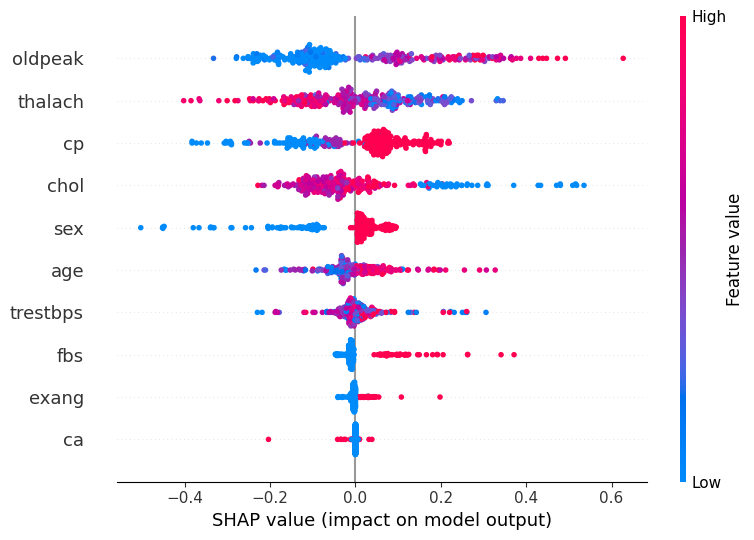

In [22]:
pipeline = Pipeline([
    ("scaler", scaler),
    ("classifier", rf)
])

explainer = shap.Explainer(pipeline.predict, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values.values, X_test, feature_names=X.columns)

- 중요도 순서 : oldpeak(ST 하강) - thalach(최대 심박수) - cp(흉통 유형) - chol(콜레스테롤) - sex(성별) - age(나이) - trestbps(혈압) - fbs(혈당) - exang(운동 유발 협심증) - ca(혈관 개수)

# 모델 저장

In [23]:
joblib.dump(rf, "model_rf.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(selected_features, "features.pkl")

print("모델 저장")

모델 저장


# ONNX 변환

In [24]:
pipeline = Pipeline([
    ("scaler", scaler),
    ("classifier", rf)
])

initial_type = [("input", FloatTensorType([None, len(selected_features)]))]

onnx_model = convert_sklearn(
    pipeline,
    initial_types=initial_type,
    target_opset=12
)

with open("heart_rf.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

print("ONNX 모델 저장")

ONNX 모델 저장


In [25]:
model = joblib.load("model_rf.pkl")
scaler = joblib.load("scaler.pkl")
features = joblib.load("features.pkl")

def predict(data):
    arr = np.array([data[f] for f in features]).reshape(1, -1)
    arr_s = scaler.transform(arr)
    return model.predict(arr_s)[0], model.predict_proba(arr_s)[0]

# 샘플 테스트
test_input = {"age": 62, "sex": 1, "trestbps": 200, "chol": 230, "fbs": 0,
 "thalach": 120, "exang": 1, "cp": 2, "oldpeak": 1.5, "ca": 2}

pred, proba = predict(test_input)
print("Prediction:", pred)
print("Probability:", proba)

Prediction: 1
Probability: [0.22664463 0.77335537]


C:\Users\NewWorld\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
